In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lstsq
from scipy.integrate import solve_ivp
from utils import *

In [2]:
# loading data
data_x0 = np.loadtxt('data/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('data/nonlinear_vectorfield_data_x1.txt')

### Task 3.1

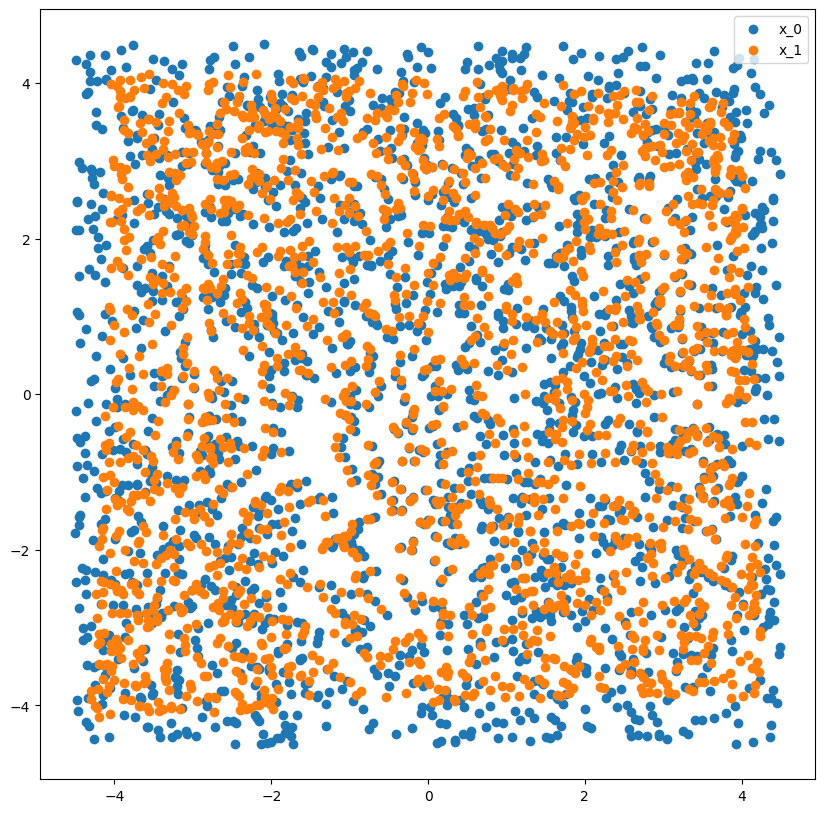

In [3]:
#plotting data
fig = plt.figure(figsize=(10,10))
plt.scatter(data_x0[:,0], data_x0[:,1], label="x_0")
plt.scatter(data_x1[:,0], data_x1[:,1], label="x_1")
plt.legend()
plt.show()

In [4]:
delta_t = 0.01
v_hat = estimate_vector(data_x0, data_x1,delta_t)

In [5]:
#Approximated A matrix
A_approximated = lstsq(data_x0, v_hat, cond=None)[0]

In [6]:
# Define linear approximation function
def linear_approximation(A, x0, delta_t):
    return x0 + delta_t * np.dot(A, x0.T)

In [7]:
predicted_x1_all = np.array([linear_approximation(A_approximated, x0, delta_t) for x0 in data_x0])
mse_all = np.mean(np.square(data_x1 - predicted_x1_all))
print(f'Mean Squared Error: {mse_all}')

Mean Squared Error: 0.0186434856287006


In [8]:
Tend = 0.01
x1_hat = generate(data_x0,Tend,A_approximated)

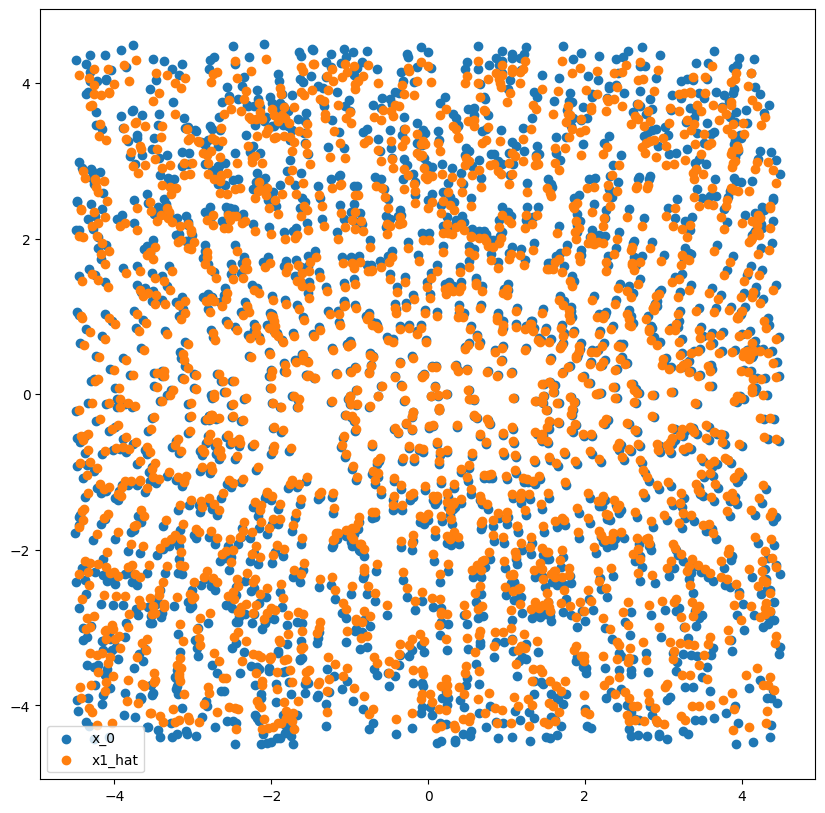

In [9]:
#plotting approximated data
fig = plt.figure(figsize=(10,10))
plt.scatter(data_x0[:,0], data_x0[:,1], label="x_0")
plt.scatter(x1_hat[:,0], x1_hat[:,1], label="x1_hat")
plt.legend()
plt.show()

In [10]:
# mse = np.linalg.norm(x1_hat-data_x1) ** 2 / len(data_x1)
# print(mse)

### Task 3.2

In [11]:
def radial_basis_function(data, l, eps):
    phi = []
    np.random.seed(42)
    x_l = np.random.choice(len(data), l, replace=False)

    for i in range(l):
        normalized_values = data - data[x_l[i]]
        phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
        phi.append(phi_l)

    return np.array(phi).T  # Transpose to have shape (number of data points, number of RBFs)

In [12]:
# Approximate the vector field using RBF
def rbf_approximation(coefficients):
    return np.dot(phi, coefficients)

In [13]:
larray = [800, 900, 1000]
epsarray = [1.5, 2, 2.5]
mse_rbf_array = []
mse_rbf_least = -10
eps_least = 0
l_least = 0

for l in larray:
    for eps in epsarray:
        
        phi = radial_basis_function(data_x0, l, eps)
        
        # Perform linear regression to estimate coefficients
        coefficients = lstsq(phi, v_hat, cond=None)[0]

        # Evaluate RBF approximation for all data points
        rbf_approximated_v = np.array(rbf_approximation(coefficients))

        # Calculate Mean Squared Error
        mse_rbf = np.mean(np.square(v_hat - rbf_approximated_v))
        mse_rbf_array.append((l, eps, mse_rbf))

        if mse_rbf > mse_rbf_least:
            mse_rbf_least = mse_rbf
            eps_least = eps
            l_least = l
        
print(f'Least mean Squared Error (RBF): {mse_rbf_least} reached for: l={l_least}, eps={eps_least}')

Least mean Squared Error (RBF): 7.787170835456e-12 reached for: l=800, eps=1.5


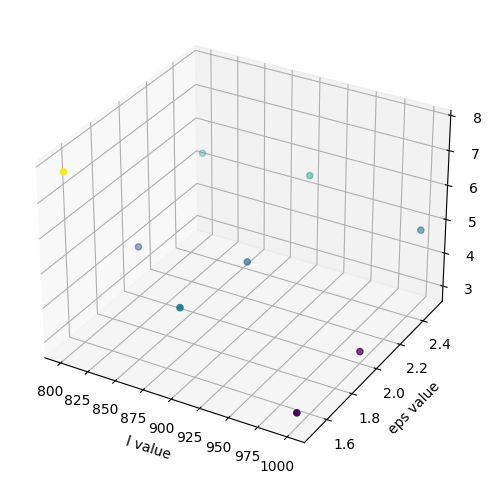

In [14]:
l, eps, mse_rbf = zip(*mse_rbf_array)

# Convert to numpy arrays
l = np.array(l)
eps = np.array(eps)
mse_rbf = np.array(mse_rbf)

# Get unique values in l and eps
unique_l = np.unique(l)
unique_eps = np.unique(eps)

# Reshape to 2D arrays
l = l.reshape((len(unique_eps), len(unique_l)))
eps = eps.reshape((len(unique_eps), len(unique_l)))
mse_rbf = mse_rbf.reshape((len(unique_eps), len(unique_l)))

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with colors based on mse_rbf values
scatter = ax.scatter(l, eps, mse_rbf, c=mse_rbf, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('l value')
ax.set_ylabel('eps value')
ax.set_zlabel('mse_rbf')
#ax.set_title('3D Surface Plot')

# Show the plot
plt.show()


### Task 3.3

In [14]:
t_final = 10  # Adjust as needed
delta_t = 0.01
num_steps = int((t_final) / delta_t) + 1

In [15]:
def simulate_system(vector_field, initial_points, t_final, delta_t, coefficients, phi):
    t_span = (0, t_final)
    t_eval = np.linspace(0, t_final, int((t_final) / delta_t) + 1)
    solution = np.zeros((len(initial_points), 2, len(t_eval)))

    for i, initial_point in enumerate(initial_points):
        sol = solve_ivp(vector_field, y0=initial_point, t_span=t_span, args=(coefficients, phi), t_eval=t_eval)
        solution[i, :, :] = sol.y 

    return solution

# def simulate_system(vector_field, initial_points, t_final, delta_t, coefficients, phi):
#     t_span = (0, t_final)
#     t_eval = np.linspace(0, t_final, int((t_final) / delta_t) + 1)
#     solution = np.zeros((len(initial_points) // 2, 2, len(t_eval)))

#     for i in range(0, len(initial_points), 2):
#         initial_point = initial_points[i:i+2]
#         sol = solve_ivp(vector_field, y0=initial_point, t_span=t_span, args=(coefficients, phi), t_eval=t_eval)
#         solution[i//2, :, :] = sol.y 

#     return solution

def rbf_approximation_sim(t, y, coefficients, phi):
    # Assuming y is not used, modify as needed
    return phi @ coefficients

In [16]:
initial_points = data_x0

# Simulate the system using the RBF model
solution_rbf = simulate_system(rbf_approximation_sim, initial_points, t_final, delta_t, coefficients, phi)

ValueError: could not broadcast input array from shape (2000,2) into shape (2,)

In [ ]:
# C_rbf = coefficients

# def evolve_system(initial_point, vector_field, time_steps, dt=0.01):
#     # Initialize the solution with the initial point
#     solution = np.zeros((time_steps + 1, len(initial_point)))
#     solution[0, :] = initial_point

#     # Evolve the system using the vector field
#     for t in range(1, time_steps + 1):
#         solution[t, :] = solution[t - 1, :] + dt * vector_field(solution[t - 1, :])

#     return solution

# # Set the larger time for system evolution
# larger_time_steps = 1000

# # Choose an initial point (you can loop over all initial points if needed)
# initial_point = data_x0[0] # select an initial point from x0

# # If using linear approximation from Task 1:
# # solution_linear = evolve_system(initial_point, lambda x: A_linear @ x, larger_time_steps)

# # If using RBF approximation from Task 2:
# solution_rbf = evolve_system(initial_point, lambda x: rbf_approximation(C_rbf), larger_time_steps)

# # plt.plot(solution_linear[:, 0], solution_linear[:, 1], label='Linear Approximation')
# plt.plot(solution_rbf[:, 0], solution_rbf[:, 1], label='RBF Approximation')
# plt.scatter(initial_point[0], initial_point[1], color='red', marker='o', label='Initial Point')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()